# Example code

Example code on how to use the Neuroimaging resources to run analytics.

### Neuroimaging

In [1]:
# 1. read MRI
from nilearn import datasets, plotting
motor_images = datasets.fetch_neurovault_motor_task()  # downloads data
# check what was downloaded
!ls -l ~/nilearn_data/neurovault/*/
# significance related image
tmap_filename = motor_images.images[0]
# 2. visualize MRI
plotting.plot_stat_map(tmap_filename, threshold=3)
print()

ModuleNotFoundError: No module named 'nilearn'

### Electrophysiology

Opening raw data file /home/delta/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Using matplotlib as 2D backend.


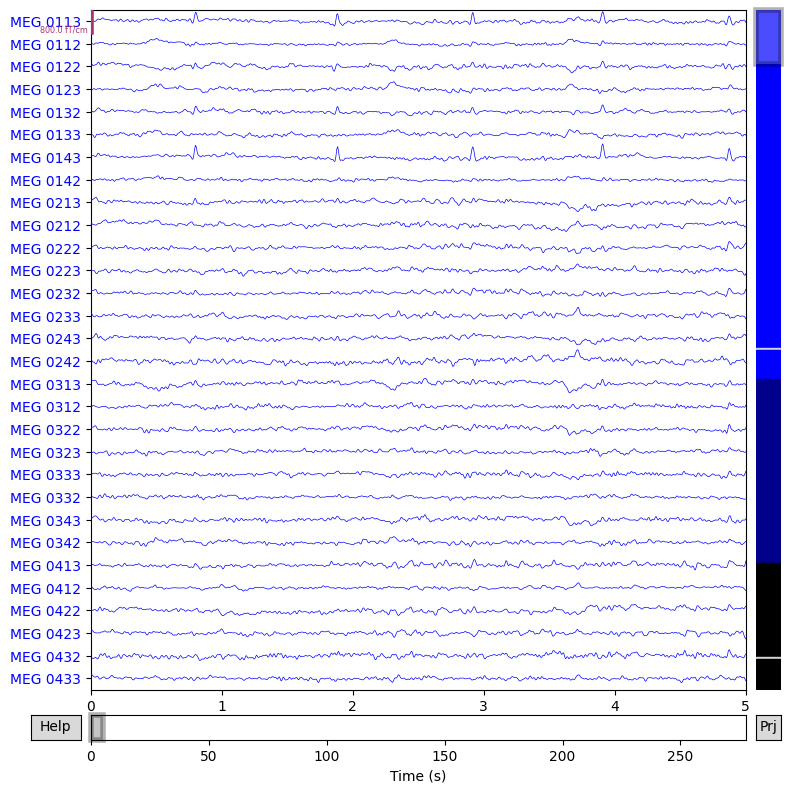

In [2]:
import numpy as np
import mne

# load sample data
sample_data_folder = mne.datasets.sample.data_path()  # WARNING: ~1.65GB
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

raw.plot(duration=5, n_channels=30)
print()

#### Putting it in perspective


In [3]:
def run_in_backround(raw):
    # the code for finding events and epochs
    events = mne.find_events(raw, stim_channel='STI 014')
    #print(events[:5])  # show the first 5
    event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
                  'visual/right': 4, 'smiley': 5, 'buttonpress': 32}
    reject_criteria = dict(mag=4000e-15,     # 4000 fT
                           grad=4000e-13,    # 4000 fT/cm
                           eeg=150e-6,       # 150 µV
                           eog=250e-6)       # 250 µV
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                        reject=reject_criteria, preload=True)

    # conditions
    conds_we_care_about = ['auditory/left', 'auditory/right',
                           'visual/left', 'visual/right']
    epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
    aud_epochs = epochs['auditory']
    aud_evoked = aud_epochs.average()
    return aud_evoked

In [4]:
%%capture
aud_evoked = run_in_backround(raw)  # finding evoked potentials - check code in notebook

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


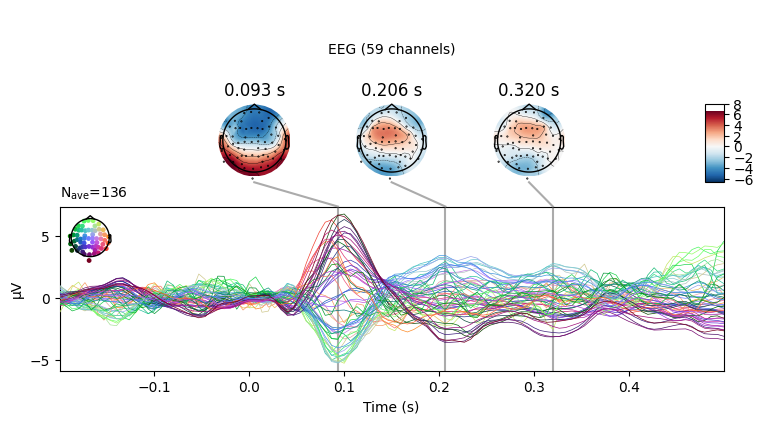

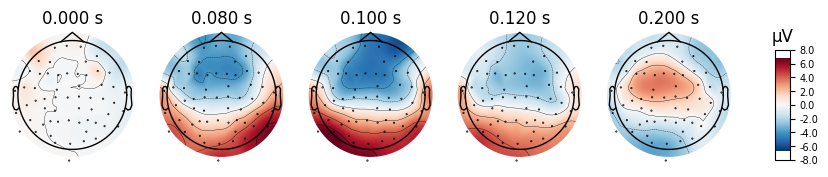

In [5]:
aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')
print()

### Datascience for tabular medical data 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.scoring import f1_score # TODO: check which one is best
from lightgbm import LGBMClassifier

# get data
df = pd.read_csv('data/ADNI.csv')
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('DX', axis=1), df['DX'], test_size=1/3, random_state=0
)

# create classifier
classifier = LGBMClassifier()
classifier.fit(X_train, y_train)
print(f1_score(X_test, y_test))


<img width="800px" class="center-block" src="../images/neuro/4.adni-sensitivity.png">

<img width="800px" class="center-block" src="../images/neuro/4.nacc-sensitivity.png">
